# LEDITS++: Limitless Image Editing using Text-to-Image Models
In this Jupyter notebook we present examples for the implementation of LEDITS++. We included pipelines for Stable Diffusion, SD-XL and DeepFloyd-IF.

But first let us install ledits.

In [1]:
!pip install git+https://github.com/ml-research/ledits_pp.git

  Cloning https://github.com/ml-research/ledits_pp.git to /tmp/pip-req-build-kucj96ns
  Running command git clone --filter=blob:none --quiet https://github.com/ml-research/ledits_pp.git /tmp/pip-req-build-kucj96ns
  Resolved https://github.com/ml-research/ledits_pp.git to commit c2ccffb9d65d39da6f696676d85d09b62fdc8bd5
  Preparing metadata (setup.py) ... done


At this point make sure that you have selected a TPU runtime and restart your session afterwards. 

In [2]:
# Auxilary methods and imports 
import torch
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import requests
from typing import Union
import PIL

def load_image(image: Union[str, PIL.Image.Image]):
    """
    Loads `image` to a PIL Image.

    Args:
        image (`str` or `PIL.Image.Image`):
            The image to convert to the PIL Image format.
    Returns:
        `PIL.Image.Image`:
            A PIL Image.
    """
    if isinstance(image, str):
        if image.startswith("http://") or image.startswith("https://"):
            image = PIL.Image.open(requests.get(image, stream=True).raw)
        elif os.path.isfile(image):
            image = PIL.Image.open(image)
        else:
            raise ValueError(
                f"Incorrect path or url, URLs must start with `http://` or `https://`, and {image} is not a valid path"
            )
    elif isinstance(image, PIL.Image.Image):
        image = image
    else:
        raise ValueError(
            "Incorrect format used for image. Should be an url linking to an image, a local path, or a PIL image."
        )
    image = PIL.ImageOps.exif_transpose(image)
    image = image.convert("RGB")
    return image

def image_grid(imgs, rows, cols, spacing = 20):
    assert len(imgs) == rows * cols
    
    w, h = imgs[0].size
    
    grid = Image.new('RGBA', size=(cols * w + (cols-1)*spacing, rows * h + (rows-1)*spacing ), color=(255,255,255,0))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=( i // rows * (w+spacing), i % rows * (h+spacing)))
        #print(( i // rows * w, i % rows * h))
    return grid

## Stable Diffusion
Now we load the LEDITS implementation for Stable Diffusion. In this case we download version 1.5 from huggingface.

In [3]:
from leditspp.scheduling_dpmsolver_multistep_inject import DPMSolverMultistepSchedulerInject
from leditspp import  StableDiffusionPipeline_LEDITS

model = 'runwayml/stable-diffusion-v1-5'
#model = '/workspace/StableDiff/models/stable-diffusion-v1-5'

device = 'cuda'

pipe = StableDiffusionPipeline_LEDITS.from_pretrained(model,safety_checker = None,)
pipe.scheduler = DPMSolverMultistepSchedulerInject.from_pretrained(model, subfolder="scheduler"
                                                             , algorithm_type="sde-dpmsolver++", solver_order=2)
pipe.to(device)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

This pipeline only supports DDIMScheduler and DPMSolverMultistepSchedulerInject. The scheduler has been changed to DPMSolverMultistepSchedulerInject.
You have disabled the safety checker for <class 'leditspp.pipeline_stable_diffusion_ledits.StableDiffusionPipeline_LEDITS'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


StableDiffusionPipeline_LEDITS {
  "_class_name": "StableDiffusionPipeline_LEDITS",
  "_diffusers_version": "0.20.2",
  "_name_or_path": "runwayml/stable-diffusion-v1-5",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "leditspp",
    "DPMSolverMultistepSchedulerInject"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

Let us now generate some of the examples presented in the paper

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.41it/s]
/home/haiyue/anaconda3/envs/leditspp/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:30<00:00,  1.64it/s]


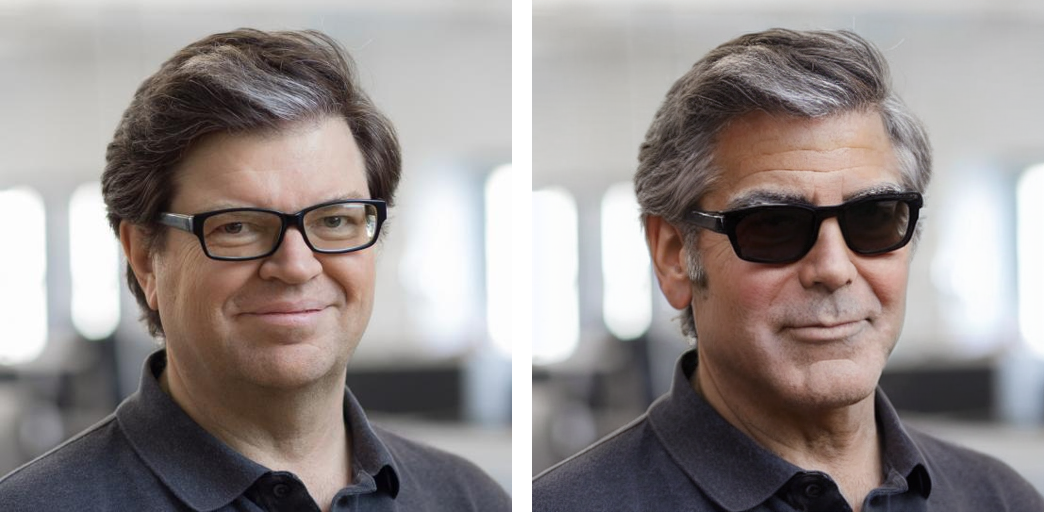

In [4]:
org = load_image('https://github.com/ml-research/ledits_pp/blob/main/examples/images/yann-lecun.jpg?raw=true').resize((512,512))
im = np.array(org)[:, :, :3]

gen = torch.manual_seed(42)
with torch.no_grad():
    _ = pipe.invert(im, num_inversion_steps=50, generator=gen, verbose=True, skip=0.15)
    out = pipe(editing_prompt=['george clooney', 'sunglasses'], 
               edit_threshold=[.7,.9],
               edit_guidance_scale=[3, 4], 
               reverse_editing_direction=[False, False],
               use_intersect_mask=True,)
image_grid((org, out.images[0]), 1, 2)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:20<00:00,  2.44it/s]


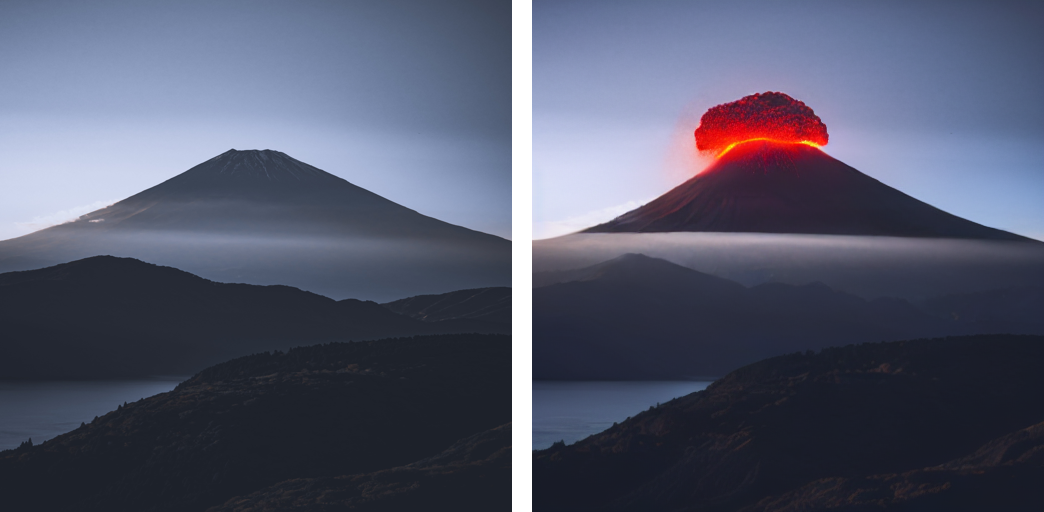

In [5]:
org = load_image('https://github.com/ml-research/ledits_pp/blob/main/examples/images/vulcano.jpg?raw=true').resize((512,512))
im = np.array(org)[:, :, :3]

gen = torch.manual_seed(9)
with torch.no_grad():
    _ = pipe.invert(im, num_inversion_steps=50, generator=gen, verbose=True, skip=0.15)
    out = pipe(editing_prompt=['vulcano eruption'], 
               edit_threshold=[.5],
               edit_guidance_scale=[15], 
               reverse_editing_direction=[False],
               use_intersect_mask=True,)
image_grid((org, out.images[0]), 1, 2)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:29<00:00,  1.70it/s]


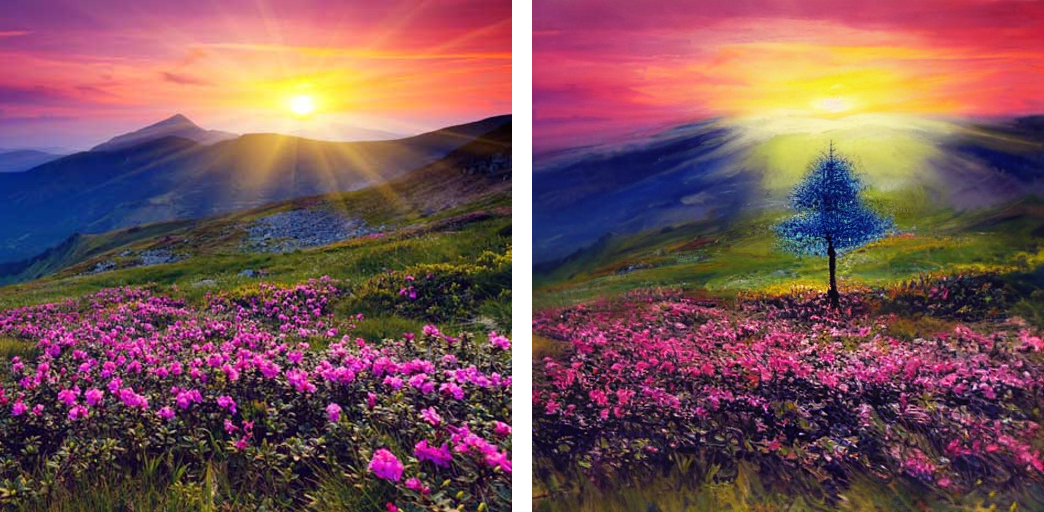

In [6]:
org = load_image('https://github.com/ml-research/ledits_pp/blob/main/examples/images/landscape.jpg?raw=true').resize((768,512)).crop((256,0,768,512))
im = np.array(org)[:, :, :3]

gen = torch.manual_seed(0)
with torch.no_grad():
    _ = pipe.invert(im, num_inversion_steps=50, generator=gen, verbose=True, skip=0.15)
    out = pipe(editing_prompt=['oilpainting', 'tree'], 
               edit_threshold=[.01,.7],
               edit_guidance_scale=[4,10], 
               reverse_editing_direction=[False, False],
               edit_warmup_steps=[8,0],
               use_intersect_mask=True)
image_grid((org, out.images[0]), 1, 2)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:20<00:00,  2.40it/s]


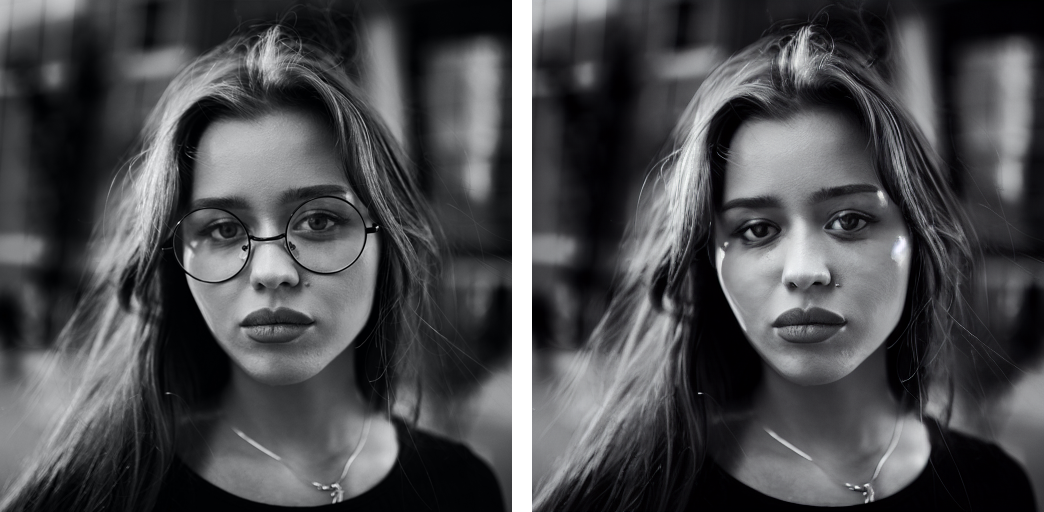

In [7]:
org = load_image('https://github.com/ml-research/ledits_pp/blob/main/examples/images/glasses.jpg?raw=true').resize((512,512))
im = np.array(org)[:, :, :3]

gen = torch.manual_seed(0)
with torch.no_grad():
    _ = pipe.invert(im, num_inversion_steps=50, generator=gen, verbose=True, skip=0.15)
    out = pipe(editing_prompt=['glasses'], 
               edit_threshold=[.95],
               edit_guidance_scale=[3], 
               reverse_editing_direction=[True],
               use_intersect_mask=True)
image_grid((org, out.images[0]), 1, 2)

## Other examples

Now let us explore some of the other properties of LEDITS++ with two examples. Specifically, we are going to take a look at probabilistic sampling and the effect of scale and threshold. 

### Sampling
Below we execute the same editing prompt multiple times while only changing the seed, which results in rich variations of the edit. 

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [05:02<00:00, 30.25s/it]

Original:


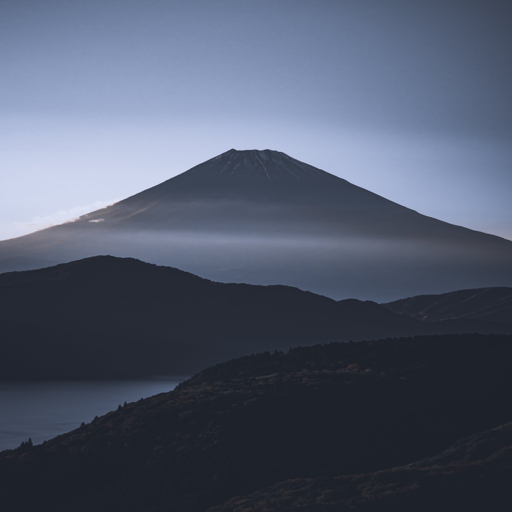

Samples:


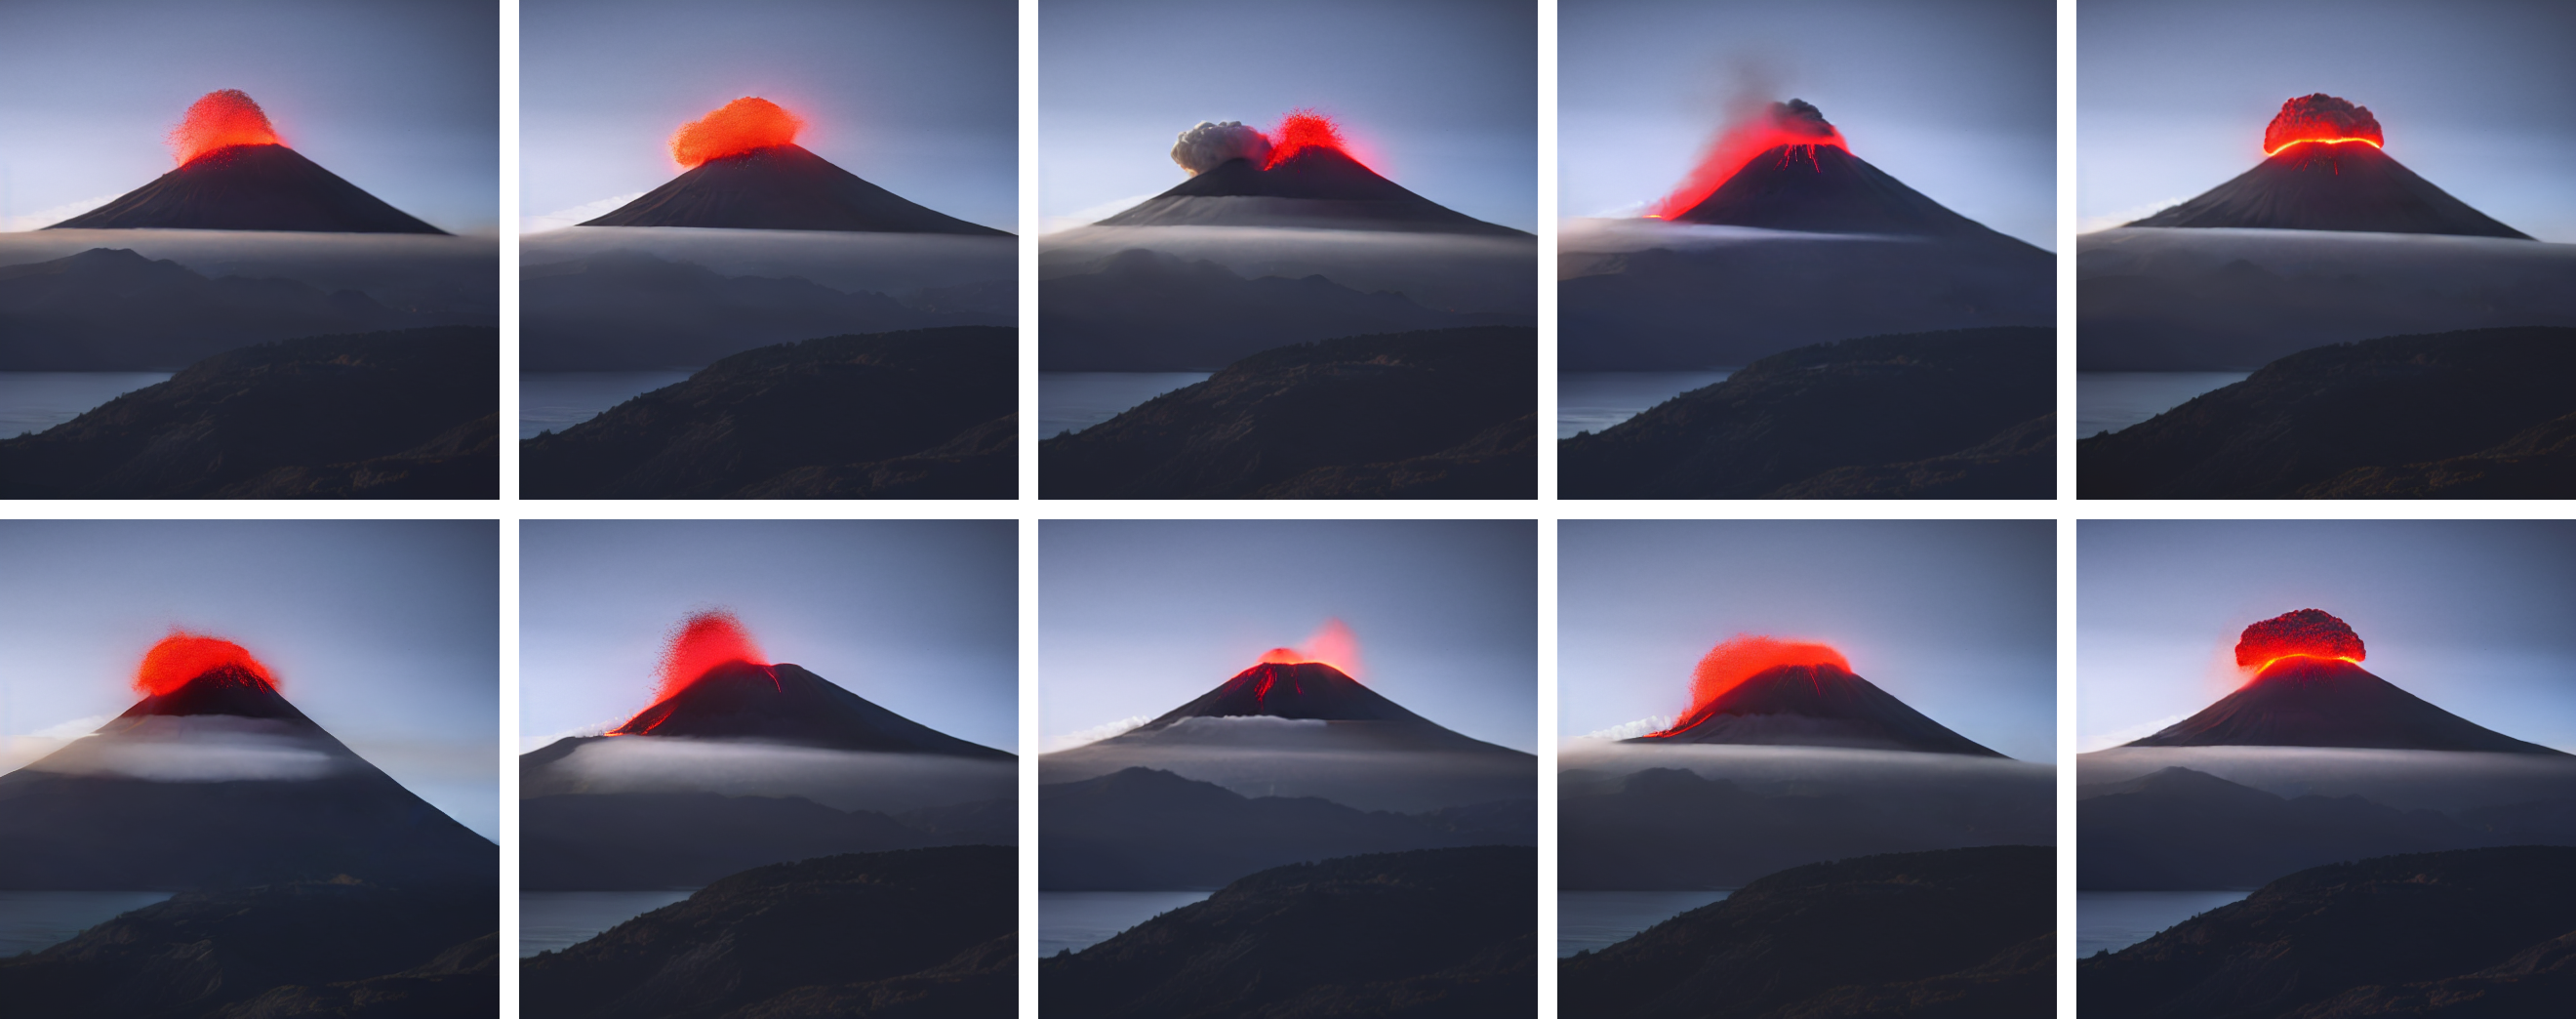

In [8]:
# Sampling
from tqdm import tqdm

org = load_image('https://github.com/ml-research/ledits_pp/blob/main/examples/images/vulcano.jpg?raw=true').resize((512,512))
im = np.array(org)[:, :, :3]

ims = []
for seed in tqdm(range(10)):
    gen = torch.manual_seed(seed)
    with torch.no_grad():
        _ = pipe.invert(im, num_inversion_steps=50, generator=gen, verbose=False, skip=0.15)
        out = pipe(editing_prompt=['vulcano eruption'], 
                   edit_threshold=[.5],
                   edit_guidance_scale=[15], 
                   reverse_editing_direction=[False],
                   use_intersect_mask=True,
                  verbose=False)
    ims.append(out.images[0])
print('\033[1mOriginal:\033[0m')
display(org)
print('\033[1mSamples:\033[0m')
image_grid(ims, 2, 5)

### Guidance Scale
Below we demonstrate how varying the guidance scale is reflected in the output image

In [ ]:
org = load_image('https://github.com/ml-research/ledits_pp/blob/main/examples/images/portrait.png?raw=true').resize((512,768))
im = np.array(org)[:, :, :3]

ims = []



gen = torch.manual_seed(2)
with torch.no_grad():    
    _ = pipe.invert(im, num_inversion_steps=50, generator=gen, verbose=True, skip=0.1)
scales = [-10,-6,-2,0,2,6,10]
for scale in scales:    
    with torch.no_grad():              
        out = pipe(editing_prompt=['smiling'], 
                   edit_threshold=[.9],
                   edit_guidance_scale=[scale], 
                   reverse_editing_direction=[False],
                   edit_warmup_steps=[5],
                   use_intersect_mask=False)
    print(f'Scale: {scale}')
    display(image_grid((org, out.images[0]), 1, 2))

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████            | 45/50 [00:29<00:02,  2.09it/s]

### Threshold
Lastly we provide an example demonstrating how an edit varies with decreasing threshold

In [ ]:
org = load_image('https://github.com/ml-research/ledits_pp/blob/main/examples/images/yann-lecun.jpg?raw=true').resize((512,512))
im = np.array(org)[:, :, :3]

ims = []



gen = torch.manual_seed(42)
with torch.no_grad():    
    _ = pipe.invert(im, num_inversion_steps=50, generator=gen, verbose=True, skip=0.15)
threshold = [.5,.6,.7,.8,.9,.95,.99]
for th in threshold:    
    with torch.no_grad():              
        out = pipe(editing_prompt=['george clooney'], 
           edit_threshold=[th],
           edit_guidance_scale=[3], 
           reverse_editing_direction=[False],
           use_intersect_mask=True,)
    print(f'Threshold: {th}')
    display(image_grid((org, out.images[0]), 1, 2))

# SD-XL
Below we provide an example for LEDITS based on SD-XL instead. The interface is generally the same (apart from the fact that SD-Xl takes file paths as inputs), but inference time increases signficantly. However, SD-XL will also produce higher resolution and quality outputs. 

In [ ]:
from leditspp.scheduling_dpmsolver_multistep_inject import DPMSolverMultistepSchedulerInject
from leditspp import StableDiffusionPipelineXL_LEDITS

model = 'stabilityai/stable-diffusion-xl-base-1.0'
#model = '/workspace/StableDiff/models/stable-diffusion-xl-base-1.0/'

device = 'cuda'

pipe = StableDiffusionPipelineXL_LEDITS.from_pretrained(model,safety_checker = None,)
pipe.scheduler = DPMSolverMultistepSchedulerInject.from_pretrained(model, subfolder="scheduler"
                                                             , algorithm_type="sde-dpmsolver++", solver_order=2)
pipe.to(device)


In [ ]:
org = load_image('https://github.com/ml-research/ledits_pp/blob/main/examples/images/pexels-tennis.jpg?raw=true'.resize((1024,1024))
im = np.array(org)[:, :, :3]

gen = torch.manual_seed(0)
with torch.no_grad():
    _ = pipe.invert('images/pexels-tennis.jpg', num_inversion_steps=100, generator=gen, verbose=True, skip=0.15)
    out = pipe(editing_prompt=['tennis ball', 'tomato'], 
               edit_threshold=[.875, .875],
               edit_guidance_scale=[4,7], 
               reverse_editing_direction=[True, False],
               edit_warmup_steps=[4, 6],
               use_intersect_mask=True)
image_grid((org.resize((512,512)), out.images[0].resize((512,512))), 1, 2)

# DeepFloyd-IF
Lastly we provide an example based on the Deepfloyd-IF which, contrary to the oder to models, is a pixel-based architecture. 
Please be advised that the checkpoint downloading may take some time and even with cpu offloading the model requires about 30GB of VRAM.

In [ ]:
from leditspp.scheduling_dpmsolver_multistep_inject import DPMSolverMultistepSchedulerInject
from leditspp import IFDiffusion_LEDITS
import torch
from diffusers import DiffusionPipeline
from diffusers.utils import pt_to_pil

# stage 1
model_1 = "DeepFloyd/IF-I-XL-v1.0"
#model_1 = "/workspace/StableDiff/models/IF-I-XL-v1.0/"
stage_1 = IFDiffusion_LEDITS.from_pretrained(model_1, watermarker=None, safety_checker=None)
stage_1.enable_model_cpu_offload()
stage_1.scheduler = DPMSolverMultistepSchedulerInject.from_pretrained(model_1, subfolder="scheduler"
                                                             , algorithm_type="sde-dpmsolver++", solver_order=2)
# stage 2
model_2 = "DeepFloyd/IF-II-L-v1.0"
#model_2 = "/workspace/StableDiff/models/IF-II-L-v1.0/"
stage_2 = DiffusionPipeline.from_pretrained(
    "/workspace/StableDiff/models/IF-II-L-v1.0/", text_encoder=None, watermarker=None, safety_checker=None
)
stage_2.enable_model_cpu_offload()

## Stage 1
IF is a hierarchical, multi-stage architecture whith each stage increasing in resolution. The first stage produces a 64x64 image. 

In [ ]:
from PIL import Image
org = load_image('https://github.com/ml-research/ledits_pp/blob/main/examples/images/vase_01.jpeg?raw=true'.resize((1024,1024))
org.save('vase_01.jpeg')
with torch.no_grad():
    gen = torch.manual_seed(42)    
    stage_1.invert('vase_01.jpeg', num_inversion_steps=50, generator=gen, skip=0.1)
    image = stage_1(prompt='', output_type="pt", 
                    editing_prompt='daisies', edit_threshold=0.8, edit_guidance_scale=8, edit_warmup_steps=5, use_intersect_mask=True
    ).images
image_grid((org.resize((64,64)), pt_to_pil(image)[0]), 1, 2)



## Stage 2
The next stage will now scale up the image to a 256x256 image. For this stage performing the inversion and subsequent guidance during generation is optional. We observed that simple running this stage with an empty prompt will give a good reconstruction and preserve any introduced edits. The error by not perfoming the inversion is comparable to that of the Stable Diffusion VAE. 

In [ ]:
with torch.no_grad():
    prompt_embeds, negative_prompt_embeds,_ , _ = stage_1.encode_prompt('')
    out = stage_2(
    image=image,
    prompt_embeds=prompt_embeds,
    negative_prompt_embeds=negative_prompt_embeds,
    output_type="pt",
    ).images
image_grid((org.resize((256,256)), pt_to_pil(out)[0]), 1, 2)

In [ ]:
#Additional example 
from PIL import Image
org = load_image('https://github.com/ml-research/ledits_pp/blob/main/examples/images/cat.jpg?raw=true'.resize((1024,1024))
org.save('cat.jpg')
with torch.no_grad():
    gen = torch.manual_seed(42)    
    stage_1.invert('cat.jpg', num_inversion_steps=50, generator=gen, skip=0.15)
    image = stage_1(prompt='', output_type="pt", 
                    editing_prompt='sunglasses', edit_threshold=0.925, edit_guidance_scale=6, edit_warmup_steps=5, use_intersect_mask=True
    ).images
    
    prompt_embeds, negative_prompt_embeds,_ , _ = stage_1.encode_prompt('')
    out = stage_2(
    image=image,
    prompt_embeds=prompt_embeds,
    negative_prompt_embeds=negative_prompt_embeds,
    output_type="pt",
    ).images
image_grid((org.resize((256,256)), pt_to_pil(out)[0]), 1, 2)
